In [1]:
import random
import torch
import fastai
import lightgbm as lgbm
import pickle
import seaborn as sns
import os
import dataframe_utilities_in_code_folder as my_util
import warnings
import category_encoders as ce
import xgboost as xgb
import pickle
import fastprogress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pip install -U bentoml
# pip install redis
# pip install ray[tune]
# pip install ray[rllib]
# pip install bayesian-optimization
# pip install ray[default]
from ray.tune import suggest

from ray import tune

from ray.tune.schedulers import PopulationBasedTraining
from hyperopt import fmin, tpe, hp, Trials
from fastprogress.fastprogress import force_console_behavior

%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.tabular import *

from fastai.tabular.all import *
from ray.tune import Analysis
from ray.tune.schedulers import ASHAScheduler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from functools import partial



In [2]:


encoder_model_path = os.getcwd()+"/data/encoder_model.pk"
df_w_features_path = os.getcwd()+"/data/df_w_features.csv"
if(not os.path.exists(df_w_features_path)):
    open(df_w_features_path, 'w').close()



In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Data

In [4]:

df = pd.read_csv(df_w_features_path, low_memory=False)

df.shape

(3960, 599)

In [5]:
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win
# columns = "["
# for i in df:
#     if(i not in ['home_team_win', 'game_id']):
#         columns += "'{}',".format(i)
# print(columns)

In [6]:
mask = pd.to_datetime(X['date'],unit='s')>=pd.to_datetime('20-07-2021') #last time model was run
new_len = mask.sum() + 300 #add 300 more records to include old validation data, but none of the training data
X_train = X[:-new_len]
y_train = y[:-new_len]
X_valid = X[-new_len:]
y_valid = y[-new_len:]

# Benchmark

In [7]:
if(not os.path.exists(encoder_model_path)):
    cat_attribs = ['home_team_abbr','away_team_abbr','date','is_night_game','home_pitcher','away_pitcher','home_trueskill_pre','away_trueskill_pre','ts_diff','home_team_rest','away_team_rest','home_pitcher_rest','away_pitcher_rest','team_rest_diff','pitcher_rest_diff','season','month','week_num','dow','dh_game_no','home_batting_batting_avg_10RA','home_batting_leverage_index_avg_10RA','home_batting_onbase_perc_10RA','home_batting_onbase_plus_slugging_10RA','away_batting_batting_avg_10RA','away_batting_leverage_index_avg_10RA','away_batting_onbase_perc_10RA','away_batting_onbase_plus_slugging_10RA','batting_batting_avg_10RA_diff','batting_leverage_index_avg_10RA_diff','batting_onbase_perc_10RA_diff','batting_onbase_plus_slugging_10RA_diff','home_team_pitching_earned_run_avg_10RA','home_team_pitching_SO_batters_faced_10RA','home_team_pitching_H_batters_faced_10RA','home_team_pitching_BB_batters_faced_10RA','away_team_pitching_earned_run_avg_10RA','away_team_pitching_SO_batters_faced_10RA','away_team_pitching_H_batters_faced_10RA','away_team_pitching_BB_batters_faced_10RA','team_pitching_earned_run_avg_10RA_diff','team_pitching_SO_batters_faced_10RA_diff','team_pitching_H_batters_faced_10RA_diff','team_pitching_BB_batters_faced_10RA_diff','home_pitcher_earned_run_avg_10RA','home_pitcher_SO_batters_faced_10RA','home_pitcher_H_batters_faced_10RA','home_pitcher_BB_batters_faced_10RA','away_pitcher_earned_run_avg_10RA','away_pitcher_SO_batters_faced_10RA','away_pitcher_H_batters_faced_10RA','away_pitcher_BB_batters_faced_10RA','pitcher_earned_run_avg_10RA_diff','pitcher_SO_batters_faced_10RA_diff','pitcher_H_batters_faced_10RA_diff','pitcher_BB_batters_faced_10RA_diff','home_team_season','away_team_season','home_team_errors_mean','home_team_errors_stdev','home_team_errors_skew','away_team_errors_mean','away_team_errors_stdev','away_team_errors_skew','home_team_spread_mean','home_team_spread_stdev','home_team_spread_skew','away_team_spread_mean','away_team_spread_stdev','away_team_spread_skew','home_team_wins_mean','home_team_wins_stdev','home_team_wins_skew','away_team_wins_mean','away_team_wins_stdev','away_team_wins_skew','error_diff','spread_diff','wins_diff','home_batting_A_mean','home_batting_A_stdev','home_batting_A_skew','home_batting_AB_mean','home_batting_AB_stdev','home_batting_AB_skew','home_batting_BB_mean','home_batting_BB_stdev','home_batting_BB_skew','home_batting_H_mean','home_batting_H_stdev','home_batting_H_skew','home_batting_PA_mean','home_batting_PA_stdev','home_batting_PA_skew','home_batting_PO_mean','home_batting_PO_stdev','home_batting_PO_skew','home_batting_R_mean','home_batting_R_stdev','home_batting_R_skew','home_batting_RBI_mean','home_batting_RBI_stdev','home_batting_RBI_skew','home_batting_SO_mean','home_batting_SO_stdev','home_batting_SO_skew','home_batting_batting_avg_mean','home_batting_batting_avg_stdev','home_batting_batting_avg_skew','home_batting_leverage_index_avg_mean','home_batting_leverage_index_avg_stdev','home_batting_leverage_index_avg_skew','home_batting_onbase_perc_mean','home_batting_onbase_perc_stdev','home_batting_onbase_perc_skew','home_batting_onbase_plus_slugging_mean','home_batting_onbase_plus_slugging_stdev','home_batting_onbase_plus_slugging_skew','home_batting_pitches_mean','home_batting_pitches_stdev','home_batting_pitches_skew','home_batting_re24_bat_mean','home_batting_re24_bat_stdev','home_batting_re24_bat_skew','home_batting_slugging_perc_mean','home_batting_slugging_perc_stdev','home_batting_slugging_perc_skew','home_batting_strikes_total_mean','home_batting_strikes_total_stdev','home_batting_strikes_total_skew','home_batting_wpa_bat_mean','home_batting_wpa_bat_stdev','home_batting_wpa_bat_skew','home_batting_wpa_bat_neg_mean','home_batting_wpa_bat_neg_stdev','home_batting_wpa_bat_neg_skew','home_batting_wpa_bat_pos_mean','home_batting_wpa_bat_pos_stdev','home_batting_wpa_bat_pos_skew','away_batting_A_mean','away_batting_A_stdev','away_batting_A_skew','away_batting_AB_mean','away_batting_AB_stdev','away_batting_AB_skew','away_batting_BB_mean','away_batting_BB_stdev','away_batting_BB_skew','away_batting_H_mean','away_batting_H_stdev','away_batting_H_skew','away_batting_PA_mean','away_batting_PA_stdev','away_batting_PA_skew','away_batting_PO_mean','away_batting_PO_stdev','away_batting_PO_skew','away_batting_R_mean','away_batting_R_stdev','away_batting_R_skew','away_batting_RBI_mean','away_batting_RBI_stdev','away_batting_RBI_skew','away_batting_SO_mean','away_batting_SO_stdev','away_batting_SO_skew','away_batting_batting_avg_mean','away_batting_batting_avg_stdev','away_batting_batting_avg_skew','away_batting_leverage_index_avg_mean','away_batting_leverage_index_avg_stdev','away_batting_leverage_index_avg_skew','away_batting_onbase_perc_mean','away_batting_onbase_perc_stdev','away_batting_onbase_perc_skew','away_batting_onbase_plus_slugging_mean','away_batting_onbase_plus_slugging_stdev','away_batting_onbase_plus_slugging_skew','away_batting_pitches_mean','away_batting_pitches_stdev','away_batting_pitches_skew','away_batting_re24_bat_mean','away_batting_re24_bat_stdev','away_batting_re24_bat_skew','away_batting_slugging_perc_mean','away_batting_slugging_perc_stdev','away_batting_slugging_perc_skew','away_batting_strikes_total_mean','away_batting_strikes_total_stdev','away_batting_strikes_total_skew','away_batting_wpa_bat_mean','away_batting_wpa_bat_stdev','away_batting_wpa_bat_skew','away_batting_wpa_bat_neg_mean','away_batting_wpa_bat_neg_stdev','away_batting_wpa_bat_neg_skew','away_batting_wpa_bat_pos_mean','away_batting_wpa_bat_pos_stdev','away_batting_wpa_bat_pos_skew','batting_A_diff','batting_AB_diff','batting_BB_diff','batting_H_diff','batting_PA_diff','batting_PO_diff','batting_R_diff','batting_RBI_diff','batting_SO_diff','batting_batting_avg_diff','batting_leverage_index_avg_diff','batting_onbase_perc_diff','batting_onbase_plus_slugging_diff','batting_pitches_diff','batting_re24_bat_diff','batting_slugging_perc_diff','batting_strikes_total_diff','batting_wpa_bat_diff','batting_wpa_bat_neg_diff','batting_wpa_bat_pos_diff','home_team_pitching_BB_mean','home_team_pitching_BB_stdev','home_team_pitching_BB_skew','home_team_pitching_ER_mean','home_team_pitching_ER_stdev','home_team_pitching_ER_skew','home_team_pitching_H_mean','home_team_pitching_H_stdev','home_team_pitching_H_skew','home_team_pitching_HR_mean','home_team_pitching_HR_stdev','home_team_pitching_HR_skew','home_team_pitching_IP_mean','home_team_pitching_IP_stdev','home_team_pitching_IP_skew','home_team_pitching_R_mean','home_team_pitching_R_stdev','home_team_pitching_R_skew','home_team_pitching_SO_mean','home_team_pitching_SO_stdev','home_team_pitching_SO_skew','home_team_pitching_batters_faced_mean','home_team_pitching_batters_faced_stdev','home_team_pitching_batters_faced_skew','home_team_pitching_earned_run_avg_mean','home_team_pitching_earned_run_avg_stdev','home_team_pitching_earned_run_avg_skew','home_team_pitching_game_score_mean','home_team_pitching_game_score_stdev','home_team_pitching_game_score_skew','home_team_pitching_inherited_runners_mean','home_team_pitching_inherited_runners_stdev','home_team_pitching_inherited_runners_skew','home_team_pitching_inherited_score_mean','home_team_pitching_inherited_score_stdev','home_team_pitching_inherited_score_skew','home_team_pitching_inplay_fb_total_mean','home_team_pitching_inplay_fb_total_stdev','home_team_pitching_inplay_fb_total_skew','home_team_pitching_inplay_gb_total_mean','home_team_pitching_inplay_gb_total_stdev','home_team_pitching_inplay_gb_total_skew','home_team_pitching_inplay_ld_mean','home_team_pitching_inplay_ld_stdev','home_team_pitching_inplay_ld_skew','home_team_pitching_inplay_unk_mean','home_team_pitching_inplay_unk_stdev','home_team_pitching_inplay_unk_skew','home_team_pitching_leverage_index_avg_mean','home_team_pitching_leverage_index_avg_stdev','home_team_pitching_leverage_index_avg_skew','home_team_pitching_pitches_mean','home_team_pitching_pitches_stdev','home_team_pitching_pitches_skew','home_team_pitching_re24_def_mean','home_team_pitching_re24_def_stdev','home_team_pitching_re24_def_skew','home_team_pitching_strikes_contact_mean','home_team_pitching_strikes_contact_stdev','home_team_pitching_strikes_contact_skew','home_team_pitching_strikes_looking_mean','home_team_pitching_strikes_looking_stdev','home_team_pitching_strikes_looking_skew','home_team_pitching_strikes_swinging_mean','home_team_pitching_strikes_swinging_stdev','home_team_pitching_strikes_swinging_skew','home_team_pitching_strikes_total_mean','home_team_pitching_strikes_total_stdev','home_team_pitching_strikes_total_skew','home_team_pitching_wpa_def_mean','home_team_pitching_wpa_def_stdev','home_team_pitching_wpa_def_skew','home_team_pitching_SO_batters_faced_mean','home_team_pitching_SO_batters_faced_stdev','home_team_pitching_SO_batters_faced_skew','home_team_pitching_H_batters_faced_mean','home_team_pitching_H_batters_faced_stdev','home_team_pitching_H_batters_faced_skew','home_team_pitching_BB_batters_faced_mean','home_team_pitching_BB_batters_faced_stdev','home_team_pitching_BB_batters_faced_skew','away_team_pitching_BB_mean','away_team_pitching_BB_stdev','away_team_pitching_BB_skew','away_team_pitching_ER_mean','away_team_pitching_ER_stdev','away_team_pitching_ER_skew','away_team_pitching_H_mean','away_team_pitching_H_stdev','away_team_pitching_H_skew','away_team_pitching_HR_mean','away_team_pitching_HR_stdev','away_team_pitching_HR_skew','away_team_pitching_IP_mean','away_team_pitching_IP_stdev','away_team_pitching_IP_skew','away_team_pitching_R_mean','away_team_pitching_R_stdev','away_team_pitching_R_skew','away_team_pitching_SO_mean','away_team_pitching_SO_stdev','away_team_pitching_SO_skew','away_team_pitching_batters_faced_mean','away_team_pitching_batters_faced_stdev','away_team_pitching_batters_faced_skew','away_team_pitching_earned_run_avg_mean','away_team_pitching_earned_run_avg_stdev','away_team_pitching_earned_run_avg_skew','away_team_pitching_game_score_mean','away_team_pitching_game_score_stdev','away_team_pitching_game_score_skew','away_team_pitching_inherited_runners_mean','away_team_pitching_inherited_runners_stdev','away_team_pitching_inherited_runners_skew','away_team_pitching_inherited_score_mean','away_team_pitching_inherited_score_stdev','away_team_pitching_inherited_score_skew','away_team_pitching_inplay_fb_total_mean','away_team_pitching_inplay_fb_total_stdev','away_team_pitching_inplay_fb_total_skew','away_team_pitching_inplay_gb_total_mean','away_team_pitching_inplay_gb_total_stdev','away_team_pitching_inplay_gb_total_skew','away_team_pitching_inplay_ld_mean','away_team_pitching_inplay_ld_stdev','away_team_pitching_inplay_ld_skew','away_team_pitching_inplay_unk_mean','away_team_pitching_inplay_unk_stdev','away_team_pitching_inplay_unk_skew','away_team_pitching_leverage_index_avg_mean','away_team_pitching_leverage_index_avg_stdev','away_team_pitching_leverage_index_avg_skew','away_team_pitching_pitches_mean','away_team_pitching_pitches_stdev','away_team_pitching_pitches_skew','away_team_pitching_re24_def_mean','away_team_pitching_re24_def_stdev','away_team_pitching_re24_def_skew','away_team_pitching_strikes_contact_mean','away_team_pitching_strikes_contact_stdev','away_team_pitching_strikes_contact_skew','away_team_pitching_strikes_looking_mean','away_team_pitching_strikes_looking_stdev','away_team_pitching_strikes_looking_skew','away_team_pitching_strikes_swinging_mean','away_team_pitching_strikes_swinging_stdev','away_team_pitching_strikes_swinging_skew','away_team_pitching_strikes_total_mean','away_team_pitching_strikes_total_stdev','away_team_pitching_strikes_total_skew','away_team_pitching_wpa_def_mean','away_team_pitching_wpa_def_stdev','away_team_pitching_wpa_def_skew','away_team_pitching_SO_batters_faced_mean','away_team_pitching_SO_batters_faced_stdev','away_team_pitching_SO_batters_faced_skew','away_team_pitching_H_batters_faced_mean','away_team_pitching_H_batters_faced_stdev','away_team_pitching_H_batters_faced_skew','away_team_pitching_BB_batters_faced_mean','away_team_pitching_BB_batters_faced_stdev','away_team_pitching_BB_batters_faced_skew','team_pitching_BB_diff','team_pitching_ER_diff','team_pitching_H_diff','team_pitching_HR_diff','team_pitching_IP_diff','team_pitching_R_diff','team_pitching_SO_diff','team_pitching_batters_faced_diff','team_pitching_earned_run_avg_diff','team_pitching_game_score_diff','team_pitching_inherited_runners_diff','team_pitching_inherited_score_diff','team_pitching_inplay_fb_total_diff','team_pitching_inplay_gb_total_diff','team_pitching_inplay_ld_diff','team_pitching_inplay_unk_diff','team_pitching_leverage_index_avg_diff','team_pitching_pitches_diff','team_pitching_re24_def_diff','team_pitching_strikes_contact_diff','team_pitching_strikes_looking_diff','team_pitching_strikes_swinging_diff','team_pitching_strikes_total_diff','team_pitching_wpa_def_diff','team_pitching_SO_batters_faced_diff','team_pitching_H_batters_faced_diff','team_pitching_BB_batters_faced_diff','home_pitcher_BB_mean','home_pitcher_BB_stdev','home_pitcher_BB_skew','home_pitcher_ER_mean','home_pitcher_ER_stdev','home_pitcher_ER_skew','home_pitcher_H_mean','home_pitcher_H_stdev','home_pitcher_H_skew','home_pitcher_HR_mean','home_pitcher_HR_stdev','home_pitcher_HR_skew','home_pitcher_IP_mean','home_pitcher_IP_stdev','home_pitcher_IP_skew','home_pitcher_R_mean','home_pitcher_R_stdev','home_pitcher_R_skew','home_pitcher_SO_mean','home_pitcher_SO_stdev','home_pitcher_SO_skew','home_pitcher_batters_faced_mean','home_pitcher_batters_faced_stdev','home_pitcher_batters_faced_skew','home_pitcher_earned_run_avg_mean','home_pitcher_earned_run_avg_stdev','home_pitcher_earned_run_avg_skew','home_pitcher_game_score_mean','home_pitcher_game_score_stdev','home_pitcher_game_score_skew','home_pitcher_inherited_runners_mean','home_pitcher_inherited_runners_stdev','home_pitcher_inherited_runners_skew','home_pitcher_inherited_score_mean','home_pitcher_inherited_score_stdev','home_pitcher_inherited_score_skew','home_pitcher_inplay_fb_total_mean','home_pitcher_inplay_fb_total_stdev','home_pitcher_inplay_fb_total_skew','home_pitcher_inplay_gb_total_mean','home_pitcher_inplay_gb_total_stdev','home_pitcher_inplay_gb_total_skew','home_pitcher_inplay_ld_mean','home_pitcher_inplay_ld_stdev','home_pitcher_inplay_ld_skew','home_pitcher_inplay_unk_mean','home_pitcher_inplay_unk_stdev','home_pitcher_inplay_unk_skew','home_pitcher_leverage_index_avg_mean','home_pitcher_leverage_index_avg_stdev','home_pitcher_leverage_index_avg_skew','home_pitcher_pitches_mean','home_pitcher_pitches_stdev','home_pitcher_pitches_skew','home_pitcher_re24_def_mean','home_pitcher_re24_def_stdev','home_pitcher_re24_def_skew','home_pitcher_strikes_contact_mean','home_pitcher_strikes_contact_stdev','home_pitcher_strikes_contact_skew','home_pitcher_strikes_looking_mean','home_pitcher_strikes_looking_stdev','home_pitcher_strikes_looking_skew','home_pitcher_strikes_swinging_mean','home_pitcher_strikes_swinging_stdev','home_pitcher_strikes_swinging_skew','home_pitcher_strikes_total_mean','home_pitcher_strikes_total_stdev','home_pitcher_strikes_total_skew','home_pitcher_wpa_def_mean','home_pitcher_wpa_def_stdev','home_pitcher_wpa_def_skew','home_pitcher_SO_batters_faced_mean','home_pitcher_SO_batters_faced_stdev','home_pitcher_SO_batters_faced_skew','home_pitcher_H_batters_faced_mean','home_pitcher_H_batters_faced_stdev','home_pitcher_H_batters_faced_skew','home_pitcher_BB_batters_faced_mean','home_pitcher_BB_batters_faced_stdev','home_pitcher_BB_batters_faced_skew','away_pitcher_BB_mean','away_pitcher_BB_stdev','away_pitcher_BB_skew','away_pitcher_ER_mean','away_pitcher_ER_stdev','away_pitcher_ER_skew','away_pitcher_H_mean','away_pitcher_H_stdev','away_pitcher_H_skew','away_pitcher_HR_mean','away_pitcher_HR_stdev','away_pitcher_HR_skew','away_pitcher_IP_mean','away_pitcher_IP_stdev','away_pitcher_IP_skew','away_pitcher_R_mean','away_pitcher_R_stdev','away_pitcher_R_skew','away_pitcher_SO_mean','away_pitcher_SO_stdev','away_pitcher_SO_skew','away_pitcher_batters_faced_mean','away_pitcher_batters_faced_stdev','away_pitcher_batters_faced_skew','away_pitcher_earned_run_avg_mean','away_pitcher_earned_run_avg_stdev','away_pitcher_earned_run_avg_skew','away_pitcher_game_score_mean','away_pitcher_game_score_stdev','away_pitcher_game_score_skew','away_pitcher_inherited_runners_mean','away_pitcher_inherited_runners_stdev','away_pitcher_inherited_runners_skew','away_pitcher_inherited_score_mean','away_pitcher_inherited_score_stdev','away_pitcher_inherited_score_skew','away_pitcher_inplay_fb_total_mean','away_pitcher_inplay_fb_total_stdev','away_pitcher_inplay_fb_total_skew','away_pitcher_inplay_gb_total_mean','away_pitcher_inplay_gb_total_stdev','away_pitcher_inplay_gb_total_skew','away_pitcher_inplay_ld_mean','away_pitcher_inplay_ld_stdev','away_pitcher_inplay_ld_skew','away_pitcher_inplay_unk_mean','away_pitcher_inplay_unk_stdev','away_pitcher_inplay_unk_skew','away_pitcher_leverage_index_avg_mean','away_pitcher_leverage_index_avg_stdev','away_pitcher_leverage_index_avg_skew','away_pitcher_pitches_mean','away_pitcher_pitches_stdev','away_pitcher_pitches_skew','away_pitcher_re24_def_mean','away_pitcher_re24_def_stdev','away_pitcher_re24_def_skew','away_pitcher_strikes_contact_mean','away_pitcher_strikes_contact_stdev','away_pitcher_strikes_contact_skew','away_pitcher_strikes_looking_mean','away_pitcher_strikes_looking_stdev','away_pitcher_strikes_looking_skew','away_pitcher_strikes_swinging_mean','away_pitcher_strikes_swinging_stdev','away_pitcher_strikes_swinging_skew','away_pitcher_strikes_total_mean','away_pitcher_strikes_total_stdev','away_pitcher_strikes_total_skew','away_pitcher_wpa_def_mean','away_pitcher_wpa_def_stdev','away_pitcher_wpa_def_skew','away_pitcher_SO_batters_faced_mean','away_pitcher_SO_batters_faced_stdev','away_pitcher_SO_batters_faced_skew','away_pitcher_H_batters_faced_mean','away_pitcher_H_batters_faced_stdev','away_pitcher_H_batters_faced_skew','away_pitcher_BB_batters_faced_mean','away_pitcher_BB_batters_faced_stdev','away_pitcher_BB_batters_faced_skew','pitcher_BB_diff','pitcher_ER_diff','pitcher_H_diff','pitcher_HR_diff','pitcher_IP_diff','pitcher_R_diff','pitcher_SO_diff','pitcher_batters_faced_diff','pitcher_earned_run_avg_diff','pitcher_game_score_diff','pitcher_inherited_runners_diff','pitcher_inherited_score_diff','pitcher_inplay_fb_total_diff','pitcher_inplay_gb_total_diff','pitcher_inplay_ld_diff','pitcher_inplay_unk_diff','pitcher_leverage_index_avg_diff','pitcher_pitches_diff','pitcher_re24_def_diff','pitcher_strikes_contact_diff','pitcher_strikes_looking_diff','pitcher_strikes_swinging_diff','pitcher_strikes_total_diff','pitcher_wpa_def_diff','pitcher_SO_batters_faced_diff','pitcher_H_batters_faced_diff','pitcher_BB_batters_faced_diff']
    full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

    encoder = full_pipeline.fit(X_train)
else:
    encoder, model = pickle.load(open(encoder_model_path,'rb'))

In [8]:
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)

# XGB

## Tune

In [9]:
import ray
def train_xgb():
    gbm = xgb.XGBClassifier(random_state=13, n_jobs=-1)
    model = gbm.set_params(early_stopping_rounds=15).fit(X_train, y_train,
                    verbose=False,
                    eval_set=[[X_train, y_train],
                                [X_valid, y_valid]]
                    )
    return model
       
model = train_xgb()

In [10]:
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]

bench_acc = accuracy_score(y_valid, xgb_test_preds)
bench_roc = roc_auc_score(y_valid, xgb_test_preds)
print(f"benchmarks:\n- Accuracy: {bench_acc*100:.1f}%\n- ROC AUC: {bench_roc:.3f}")

benchmarks:
- Accuracy: 52.6%
- ROC AUC: 0.502


## Greedy Hyperopt

In [11]:
xgb_params = {'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

In [12]:
def xgb_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
    if 'reg_alpha' in new_params.keys():
        new_params['reg_alpha']=np.exp(new_params['reg_alpha'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = xgb.XGBClassifier(**params, random_state=13, n_jobs=-1)
    model = gbm.set_params(early_stopping_rounds=15).fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]]
                    )
    xgb_test_preds = model.predict(X_valid)
    proba = model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, xgb_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return(score)

In [13]:
def get_xgbparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    if 'reg_alpha' in params.keys():
        full_params['reg_alpha']=np.exp(params['reg_alpha'])
    
    return full_params

In [14]:
space = {
    'max_depth':  hp.quniform('max_depth', 10, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 2, 10, 1),
    'learning_rate': hp.quniform('learning_rate', .01, .08, .01),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', -2, 4,0.5),
}
xgb_params = get_xgbparams(space,xgb_params,10)

100%|██████████| 10/10 [03:18<00:00, 19.81s/trial, best loss: -0.4838341736135376]


In [15]:
xgb_params

{'colsample_bytree': 0.9,
 'gamma': 1e-08,
 'learning_rate': 0.02,
 'max_depth': 16,
 'min_child_weight': 9.0,
 'reg_alpha': 0.22313016014842982,
 'subsample': 0.7000000000000001}

## Test

In [16]:
xgb_params

{'colsample_bytree': 0.9,
 'gamma': 1e-08,
 'learning_rate': 0.02,
 'max_depth': 16,
 'min_child_weight': 9.0,
 'reg_alpha': 0.22313016014842982,
 'subsample': 0.7000000000000001}

In [17]:
gbm = xgb.XGBClassifier(**xgb_params, random_state=13, n_jobs=-1)
model = gbm.set_params(early_stopping_rounds=15).fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]]
                )
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-logloss:0.69178	validation_1-logloss:0.69271
[1]	validation_0-logloss:0.69040	validation_1-logloss:0.69231
[2]	validation_0-logloss:0.68910	validation_1-logloss:0.69205
[3]	validation_0-logloss:0.68791	validation_1-logloss:0.69165
[4]	validation_0-logloss:0.68672	validation_1-logloss:0.69129
[5]	validation_0-logloss:0.68553	validation_1-logloss:0.69102
[6]	validation_0-logloss:0.68444	validation_1-logloss:0.69062
[7]	validation_0-logloss:0.68334	validation_1-logloss:0.69054
[8]	validation_0-logloss:0.68229	validation_1-logloss:0.69043
[9]	validation_0-logloss:0.68116	validation_1-logloss:0.69003
[10]	validation_0-logloss:0.67996	validation_1-logloss:0.68993
[11]	validation_0-logloss:0.67886	validation_1-logloss:0.68956
[12]	validation_0-logloss:0.67798	validation_1-logloss:0.68928
[13]	validation_0-logloss:0.67692	validation_1-logloss:0.68919
[14]	validation_0-logloss:0.67585	validation_1-logloss:0.68895
[15]	validation_0-logloss:0.67478	validation_1-logloss:0.68866
[1

(0.5504731861198738, 0.5338341736135376)

In [18]:
# create encoder_model.pk file
pickle.dump((encoder, model), open(encoder_model_path, 'wb'))


## EDA

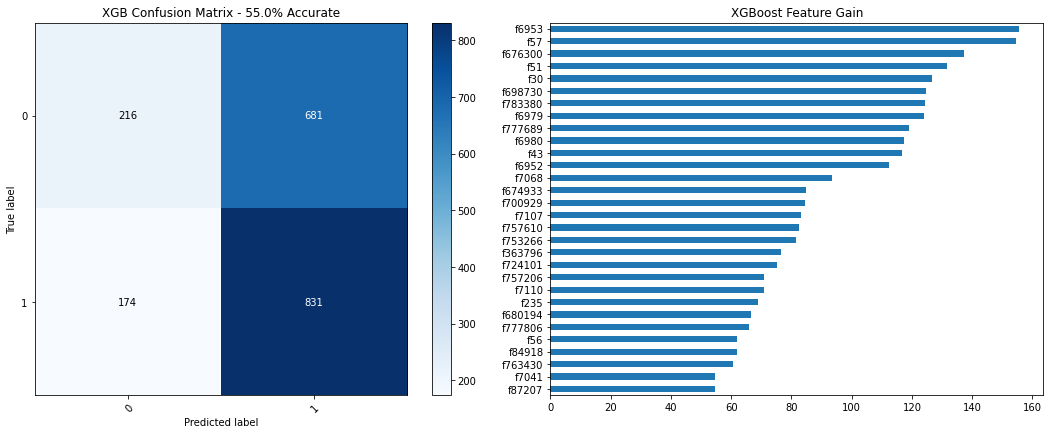

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

x = pd.Series(model.get_booster().get_score(importance_type='total_gain')
              ).sort_values()
x[-30:].plot(kind='barh', ax=ax[1], title="XGBoost Feature Gain")

my_util.plot_confusion_matrix(y_valid, xgb_test_preds, [0, 1],
                              ax=ax[0], title=f"XGB Confusion Matrix - {accuracy_score(y_valid, xgb_test_preds)*100:.1f}% Accurate")

fig.tight_layout()


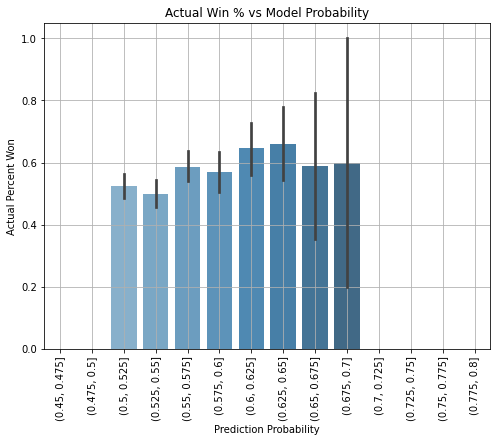

In [20]:
df = pd.DataFrame()
df['proba'] = xgb_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df.loc[df['proba'] < .5, 'bet_win'] = -df['home_win']

bins = [x/40 for x in range(18, 33)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win, palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


In [21]:
print("win % for bets with greater than x confidence:")
for x in range(10, 18):
    d = df.bet_win[df.confidence >= x/20]
    print(
        f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()*100/len(df):.1f}%")


win % for bets with greater than x confidence:
 conf: 0.50, win %:55.0%, % of total 100.0%
 conf: 0.55, win %:59.8%, % of total 43.9%
 conf: 0.60, win %:64.5%, % of total 11.6%
 conf: 0.65, win %:59.1%, % of total 1.2%
 conf: 0.70, win %:nan%, % of total 0.0%
 conf: 0.75, win %:nan%, % of total 0.0%
 conf: 0.80, win %:nan%, % of total 0.0%
 conf: 0.85, win %:nan%, % of total 0.0%


# Other Models

## LightGBM

In [22]:
lgbm_params = {
    'learning_rate': 0.65,
    'max_depth': 8,
    'subsample': 0.6,
}


In [23]:
gbm = lgbm.LGBMClassifier(**lgbm_params, random_state=-1)
model = gbm.set_params(early_stopping_rounds=15).fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]]
                )
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15


(0.5252365930599369, 0.4991114660809664)

In [24]:
def lgbm_objective(new_params, data):
    X_train, y_train, X_valid, y_valid, params = data

    if 'max_depth' in new_params.keys():
        new_params['max_depth'] = int(new_params['max_depth'])
    if 'min_data_in_leaf' in new_params.keys():
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])

    for x in new_params.keys():
        params[x] = new_params[x]

    np.random.seed(13)
    gbm = lgbm.LGBMClassifier(**params, random_state=13)
    lgbm_model = gbm.set_params(early_stopping_rounds=15).fit(X_train, y_train,
                                                              verbose=False,
                                                              eval_set=[[X_train, y_train],
                                                                        [X_valid, y_valid]]
                                                              )
    lgbm_test_preds = lgbm_model.predict(X_valid)

    proba = lgbm_model.predict_proba(X_valid)[:, 1]

    # penalize low discrimination
    score = -roc_auc_score(y_valid, lgbm_test_preds)
    if max(proba) < .7 and min(proba) > .3:
        score += 0.05

    return score


def get_lgbmparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(
        X_train, y_train, X_valid, y_valid, full_params))

    params = fmin(fmin_objective,
                  space=space,
                  algo=tpe.suggest,
                  max_evals=evals)

    # update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x] = params[x]
    full_params['max_depth'] = int(full_params['max_depth'])
    return full_params


In [25]:
space = {
    'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

100%|██████████| 25/25 [03:00<00:00,  7.21s/trial, best loss: -0.5290021464583438]


In [26]:
lgbm_params

{'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.6}

In [27]:
np.random.seed(13)
gbm = lgbm.LGBMClassifier(**lgbm_params, random_state=13)
lgbm_model = gbm.set_params(early_stopping_rounds=15).fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]]
                )
lgbm_test_preds = lgbm_model.predict(X_valid)
lgbm_test_proba = lgbm_model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15
[1]	training's binary_logloss: 0.677891	valid_1's binary_logloss: 0.691746
[2]	training's binary_logloss: 0.670778	valid_1's binary_logloss: 0.690789
[3]	training's binary_logloss: 0.662062	valid_1's binary_logloss: 0.690635
[4]	training's binary_logloss: 0.653417	valid_1's binary_logloss: 0.690361
[5]	training's binary_logloss: 0.648015	valid_1's binary_logloss: 0.690499
[6]	training's binary_logloss: 0.638582	valid_1's binary_logloss: 0.690956
[7]	training's binary_logloss: 0.632016	valid_1's binary_logloss: 0.691837
[8]	training's binary_logloss: 0.627146	valid_1's binary_logloss: 0.692206
[9]	training's binary_logloss: 0.622869	valid_1's binary_logloss: 0.693357
[10]	training's binary_logloss: 0.618238	valid_1's binary_logloss: 0.693998
[11]	training's binary_logloss: 0.613688	valid_1's binary_logloss: 0.693899
[12]	training's binary_logloss: 0.60962

(0.5289169295478444, 0.5075658496813591)

In [28]:
print(f"new model ROC: {roc_auc_score(y_valid, lgbm_test_preds):.3f}\nold model ROC: {bench_roc:.3f}\n")

new model ROC: 0.508
old model ROC: 0.502



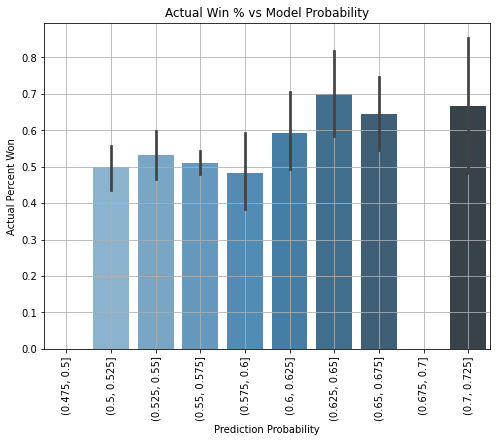

In [29]:
df = pd.DataFrame()
df['proba'] = lgbm_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df.loc[df['proba']<.5, 'bet_win'] = -df['home_win']

bins=[x/40 for x in range(19,30)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


In [30]:
print("win % for bets with greater than x confidence:")
for x in range(10,19):
    d = df.bet_win[df.confidence>x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()/6:.1f}%")

win % for bets with greater than x confidence:
 conf: 0.50, win %:52.9%, % of total 317.0%
 conf: 0.55, win %:53.4%, % of total 238.5%
 conf: 0.60, win %:64.2%, % of total 44.7%
 conf: 0.65, win %:65.0%, % of total 19.5%
 conf: 0.70, win %:66.7%, % of total 4.5%
 conf: 0.75, win %:nan%, % of total 0.0%
 conf: 0.80, win %:nan%, % of total 0.0%
 conf: 0.85, win %:nan%, % of total 0.0%
 conf: 0.90, win %:nan%, % of total 0.0%


## Fastai

In [31]:
df = pd.read_csv(df_w_features_path, low_memory=False)

df.shape

(3960, 599)

In [32]:
from fastai.tabular.data import TabularDataLoaders
from fastai.metrics import *

In [33]:
path = untar_data(URLs.MNIST_SAMPLE)
CAT_NAMES = [x for x in df.columns if df[x].dtype=='object']
CONT_NAMES = [x for x in df.columns if df[x].dtype not in ['object','bool']]
procs = [Categorify, FillMissing, Normalize]

In [34]:
# df = df.dropna(subset=['home_team_win'])
data = TabularDataLoaders.from_df(df, path, procs=procs, cat_names=CAT_NAMES, cont_names=CONT_NAMES,
                                  y_names="home_team_win", valid_idx=list(range(300)), bs=64)

data


In [35]:
config = tabular_config(ps=[.03, .3])
learn = tabular_learner(data, layers=[1000, 500],config=config, metrics=[accuracy], wd=1e-1)   

In [36]:
learn.fit_one_cycle(2)


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.496667,00:04
1,nan,nan,0.496667,00:04


In [37]:
preds, y = learn.get_preds()
preds = np.array(preds)[:, 1]
accuracy_score(y, preds > 0.5), roc_auc_score(y, preds > 0.5)


(0.49666666666666665, 0.5)

In [38]:

space = {'p2': hp.quniform('p2', 0, .8, .1),
         'emb_drop': hp.quniform('emb_drop', 0, .8, .1),
         'l1': hp.quniform('l1', 500, 1500, 100),
         }
# suppress widgets
fastprogress.fastprogress.NO_BAR = True
fastprogress.fastprogress.WRITER_FN = str


def objective(x):
    # get params from hyperopt
    p2 = x['p2']
    p1 = p2/10
    l1 = int(x['l1'])
    l2 = int(l1/2)

    # freeze seeds

    seed = 13
    random.seed(seed)  # python
    np.random.seed(seed)  # numpy
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # get to work
    config = tabular_config(ps=[p1, p2])
    learn = tabular_learner(data, layers=[l1, l2], config=config, wd=1e-1)
    learn.fit_one_cycle(2)
    preds, y = learn.get_preds(with_loss=False)
    preds = np.array(preds)
    score = -roc_auc_score(y, preds[:, 1] > 0.5)

    return {'loss': score, 'status': 'ok'}


trials = Trials()

best = fmin(objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
best


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:06


  2%|▏         | 1/50 [00:12<10:15, 12.55s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:07


  4%|▍         | 2/50 [00:27<11:16, 14.08s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:07


  6%|▌         | 3/50 [00:44<11:52, 15.16s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:07


  8%|▊         | 4/50 [00:58<11:23, 14.87s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:03
1,nan,nan,00:03


 10%|█         | 5/50 [01:06<09:16, 12.36s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:09


 12%|█▏        | 6/50 [01:23<10:20, 14.10s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:04


 14%|█▍        | 7/50 [01:33<08:57, 12.51s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:07


 16%|█▌        | 8/50 [01:48<09:29, 13.55s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:05
1,nan,nan,00:04


 18%|█▊        | 9/50 [01:59<08:37, 12.63s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:06


 20%|██        | 10/50 [02:13<08:34, 12.87s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:05


 22%|██▏       | 11/50 [02:25<08:17, 12.77s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:08


 24%|██▍       | 12/50 [02:42<08:53, 14.05s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:05
1,nan,nan,00:06


 26%|██▌       | 13/50 [02:54<08:18, 13.49s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:05


 28%|██▊       | 14/50 [03:06<07:47, 12.98s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:08


 30%|███       | 15/50 [03:23<08:15, 14.16s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:05


 32%|███▏      | 16/50 [03:35<07:44, 13.67s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:07


 34%|███▍      | 17/50 [03:50<07:41, 13.97s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:07


 36%|███▌      | 18/50 [04:05<07:32, 14.14s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:05


 38%|███▊      | 19/50 [04:15<06:42, 12.98s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:05
1,nan,nan,00:06


 40%|████      | 20/50 [04:27<06:23, 12.77s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:06


 42%|████▏     | 21/50 [04:41<06:16, 12.98s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:04


 44%|████▍     | 22/50 [04:52<05:53, 12.61s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:06


 46%|████▌     | 23/50 [05:07<05:57, 13.25s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:07


 48%|████▊     | 24/50 [05:24<06:09, 14.22s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:10


 50%|█████     | 25/50 [05:39<06:05, 14.62s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:06


 52%|█████▏    | 26/50 [05:55<05:59, 14.97s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:08


 54%|█████▍    | 27/50 [06:12<05:59, 15.65s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:04


 56%|█████▌    | 28/50 [06:21<04:58, 13.56s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:08


 58%|█████▊    | 29/50 [06:38<05:06, 14.60s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:14
1,nan,nan,00:08


 60%|██████    | 30/50 [07:02<05:48, 17.43s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:03
1,nan,nan,00:03


 62%|██████▏   | 31/50 [07:10<04:35, 14.52s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:07


 64%|██████▍   | 32/50 [07:24<04:22, 14.61s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:10
1,nan,nan,00:08


 66%|██████▌   | 33/50 [07:43<04:29, 15.87s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:05
1,nan,nan,00:05


 68%|██████▊   | 34/50 [07:55<03:52, 14.50s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:06


 70%|███████   | 35/50 [08:10<03:39, 14.66s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:09
1,nan,nan,00:07


 72%|███████▏  | 36/50 [08:27<03:37, 15.53s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:06


 74%|███████▍  | 37/50 [08:42<03:18, 15.28s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:06


 76%|███████▌  | 38/50 [08:58<03:04, 15.38s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:04


 78%|███████▊  | 39/50 [09:07<02:29, 13.58s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:03
1,nan,nan,00:04


 80%|████████  | 40/50 [09:15<02:00, 12.03s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:05


 82%|████████▏ | 41/50 [09:28<01:51, 12.33s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:06
1,nan,nan,00:05


 84%|████████▍ | 42/50 [09:40<01:36, 12.10s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:06


 86%|████████▌ | 43/50 [09:54<01:29, 12.83s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:06


 88%|████████▊ | 44/50 [10:09<01:19, 13.29s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:04


 90%|█████████ | 45/50 [10:18<01:00, 12.12s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:04
1,nan,nan,00:05


 92%|█████████▏| 46/50 [10:29<00:46, 11.58s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:08


 94%|█████████▍| 47/50 [10:45<00:38, 12.94s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:09


 96%|█████████▌| 48/50 [11:03<00:29, 14.65s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:08
1,nan,nan,00:11


 98%|█████████▊| 49/50 [11:24<00:16, 16.38s/trial, best loss: -0.5]

epoch,train_loss,valid_loss,time
0,nan,nan,00:07
1,nan,nan,00:07


100%|██████████| 50/50 [11:39<00:00, 13.99s/trial, best loss: -0.5]


{'emb_drop': 0.2, 'l1': 1200.0, 'p2': 0.7000000000000001}